In [1]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# DATA CLEANING ##

In [2]:
#Loading the dataset into the pandas dataframe
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', 200)
accept = pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression = 'gzip')
accept.shape

(2260701, 151)

In [3]:
#Drop columns which contain NaN value more than 50%
drop_cols = accept.columns[accept.isnull().mean() > 0.5]
accept = accept.drop(drop_cols,axis=1)
accept.shape

(2260701, 107)

**After drop some columns which contain more than 50% missing values, the dataset has 107 variables with 2,260,701 records.**

In [4]:
#Checking missing values
accept.isnull().sum()

id                                  0
loan_amnt                          33
funded_amnt                        33
funded_amnt_inv                    33
term                               33
int_rate                           33
installment                        33
grade                              33
sub_grade                          33
emp_title                      167002
emp_length                     146940
home_ownership                     33
annual_inc                         37
verification_status                33
issue_d                            33
loan_status                        33
pymnt_plan                         33
url                                33
purpose                            33
title                           23358
zip_code                           34
addr_state                         33
dti                              1744
delinq_2yrs                        62
earliest_cr_line                   62
fico_range_low                     33
fico_range_h

In [5]:
#removing the rows contained Nan values 
accept=accept.dropna(axis = 0).reset_index(drop = True)
accept.isnull().sum().sum()

0

In [6]:
#After check all variables, I will just keep some variables that relevant analyst purposes.
accept = accept[['loan_amnt', 'funded_amnt','term','int_rate', 'grade','sub_grade','emp_title',
                  'emp_length','home_ownership', 'annual_inc','verification_status', 'issue_d',
                 'loan_status', 'pymnt_plan', 'purpose',  'addr_state', 'disbursement_method', 
                 'application_type','initial_list_status', 'installment','fico_range_low',
                 'fico_range_high','last_fico_range_low', 'last_fico_range_high']]
#create "issue_year" column which extract from "issue_d"  analysis purpose later
accept['issue_year'] = pd.DatetimeIndex(accept['issue_d']).year

# create new column 'int_round' for analysis purpose later
accept['int_round'] = accept['int_rate'].round(0).astype(int)
accept.shape

(917472, 26)

**The dataset we will work with has 26 columns and 917,472 rows.**

In [7]:
accept.head()

,loan_amnt,funded_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,disbursement_method,application_type,initial_list_status,installment,fico_range_low,fico_range_high,last_fico_range_low,last_fico_range_high,issue_year,int_round
0,3600.0,3600.0,36 months,13.99,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,PA,Cash,Individual,w,123.03,675.0,679.0,560.0,564.0,2015,14
1,24700.0,24700.0,36 months,11.99,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,small_business,SD,Cash,Individual,w,820.28,715.0,719.0,695.0,699.0,2015,12
2,10400.0,10400.0,60 months,22.45,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,major_purchase,PA,Cash,Individual,w,289.91,695.0,699.0,700.0,704.0,2015,22
3,20000.0,20000.0,36 months,9.17,B,B2,Vice President of Recruiting Operations,10+ years,MORTGAGE,180000.0,Not Verified,Dec-2015,Fully Paid,n,debt_consolidation,MN,Cash,Individual,f,637.58,680.0,684.0,650.0,654.0,2015,9
4,20000.0,20000.0,36 months,8.49,B,B1,road driver,10+ years,MORTGAGE,85000.0,Not Verified,Dec-2015,Fully Paid,n,major_purchase,SC,Cash,Individual,w,631.26,705.0,709.0,670.0,674.0,2015,8


# DATA EXPLORATION

In [8]:
#create a class called EDA
class EDA:
    def __init__(self, data):
        self.data=data
        print(self.data.info())
    def get_stats(self):
        print("Summary Statistic of Dataset")
        print(self.data.describe())
        
        #loan purpose distrubution:
    def loan_purpose(self, col1, col2):
        purpose=self.data[col1].value_counts()
        print(purpose)
        #distribution of loan purposes
        purpose.plot.pie(autopct='%1.1f%%', shadow=False, startangle=180,
                         figsize=(12,8),fontsize=11), plt.axis('equal')
        plt.legend(loc='center left',bbox_to_anchor=(0.8,0.5),fontsize=10)
        plt.title('Distribution of Loan Purposes', fontsize=25)
        plt.show()
         # Total loan amount by purposes
        loan_by_purpose=self.data.groupby([col1])[col2].sum()/1000000.
        loan_by_purpose=loan_by_purpose.sort_values(ascending=False)
        plt.figure(figsize=(14,6))
        g=sns.barplot(loan_by_purpose.index, loan_by_purpose.values, color="blue")
        g.set_xticklabels(g.get_xticklabels(),rotation=90)
        g.set_xlabel("", fontsize=10)
        g.set_ylabel("Loan Amount (in million)", fontsize=10)
        g.set_title("Total Loan Amount by Purposes", fontsize=15)
        plt.show()
        
        #Loan by Year
    def loan_by_year(self, col1, col2, col3):
        #total loan amount by year
        loan=self.data.groupby([col2])[col1].sum()/1000000
        #print("Total Loan Amount by Years (in million)")
        print(loan)
       
        # Loan distribution Amt plot
        plt.figure(figsize = (8,12))
        plt.subplot(211)
        g1 = sns.distplot(self.data[col1])
        g1.set_xlabel("Loan Amount Value")
        g1.set_ylabel("Frequency", fontsize=10)
        g1.set_title("Loan Amount Distribuition", fontsize=15)

        #Loan by Year with Term
        total = len(self.data)
        plt.subplot(212)
        g2 = sns.countplot(x=self.data[col2], hue=self.data[col3], data=self.data)
        g2.set_xticklabels(g2.get_xticklabels(),rotation=0)
        g2.set_xlabel("Years", fontsize=10)
        g2.set_ylabel("Count Loans", fontsize=10)
        g2.set_title("Term of Loan by Years", fontsize=15)
        sizes=[]
        for p in g2.patches:
            height = p.get_height()
            sizes.append(height)
            g2.text(p.get_x()+p.get_width()/2.,height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
        g2.set_ylim(0, max(sizes) * 1.10)
        plt.subplots_adjust(hspace = 0.3,top = 0.9)
        plt.show()
        
        #Interset rate with Grade/sub-grade
    def rate(self, col1, col2, col3):
        #average interest rate by year interest
        average_rate_grade = self.data.groupby([col2])[col1].mean()
        print("Average Rate by Grades")
        print(average_rate_grade)
         
            # Rate vs. Grade 
        plt.figure(figsize=(10,8))   
        plt.subplot(211)
        order_grade = self.data.groupby([col2])[col1].count().index
        g1 = sns.boxenplot(x=self.data[col2], y=self.data[col1], data=self.data, 
                   palette="hls", order=order_grade)
        g1.set_xlabel("Grades", fontsize=10)
        g1.set_ylabel("Interest Rate", fontsize=10)
        g1.set_title("Interest Rate Distribution by Grade", fontsize=15)
                                                          
        # Rate vs. Sub-grade
        plt.subplot(212)                              
        order_sub = self.data.groupby([col3])[col1].count().index
        g2 = sns.boxenplot(x=self.data[col3], y=self.data[col1], data=self.data, 
                   palette="hls", order=order_sub)
        g2.set_xlabel("Grades", fontsize=10)
        g2.set_ylabel("Interest Rate", fontsize=10)
        g2.set_title("Interest Rate Distribution by Grade", fontsize=15)
        
        plt.subplots_adjust(hspace = 0.4,top = 0.9)
        plt.show()
       
        # Loan Amount vs. States
    def states(self, col1, col2):
        loan_by_states=self.data.groupby([col1])[col2].sum()/1000000
        
        #plot 
        loan_by_states=loan_by_states.sort_values(ascending=False)
        plt.figure(figsize=(14,6))
        g=sns.barplot(loan_by_states.index, loan_by_states.values)
        g.set_xlabel("States", fontsize=10)
        g.set_ylabel("Loan Amount (in million)", fontsize=10)
        g.set_title("Total Loan Amount by States", fontsize=15)
        plt.show()
        
        
        #Loan Vs. Annual income
    def loan_income(self, col1, col2):
        plt.figure(figsize = (8,8))
        sns.regplot(self.data[col1],self.data[col2], data=accept,color='green')
        plt.title('Loan Amount with Annual Income Relationship')
        plt.show()
        
        
        #Loan Vs. Employment titles
    def emp_title(self, col1, col2):
        #wordcloud of employment title
        titles = ' '.join(self.data[col1].str.lower())
        wordcloud = WordCloud(background_color="white", max_words=50).generate(titles)
        plt.figure(figsize = (10,8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
        #plot top 20 employement title with highest loan
        self.data[col1]=self.data[col1].str.lower()
        emp_loan=self.data.groupby([col1])[col2].sum()
        top_emp_loan = emp_loan[:20].sort_values(ascending=False)
        plt.figure(figsize=(10,6))
        top_emp_loan.plot.bar(color="green")
        plt.xlabel('Employment Title', fontsize=10)
        plt.ylabel('Loan Amount (in $)', fontsize=10)
        plt.title('Top 20 Emplemont Tittle with Highest Total Loan Amount', fontsize=15) 
        plt.show()
        
    def loan_status(self, col1, col2, col3):
        #loan status types distribution
        loan_status=self.data[col1].value_counts()
        loan_status.plot.pie(autopct='%1.1f%%', shadow=False, startangle=180,
                         figsize=(8,6),fontsize=11), plt.axis('equal')
        plt.legend(loc='center left',bbox_to_anchor=(0.8,0.5),fontsize=10)
        plt.title('Loan Status Types Distribution', fontsize=15)
        plt.show()
        
        #Loan Vs. Loan Status plot
        plt.figure(figsize = (10,5))
        g = sns.boxplot(x=self.data[col1], y=self.data[col2], data=self.data) 
        g.set_xticklabels(g.get_xticklabels(),rotation=45)
        g.set_xlabel("Loan Status Categories", fontsize=10)
        g.set_ylabel("Loan Amount Distribution", fontsize=10)
        g.set_title("Loan Status by Loan Amount", fontsize=15)
        plt.show()
        
        #plot mean rate with loan status
        rate_by_status=self.data.groupby(col1)[col3].mean()
        rate_by_status=rate_by_status.sort_values(ascending=True)
        plt.figure(figsize=(8,4))
        g1=sns.barplot(rate_by_status.index, rate_by_status.values, color="purple")
        g1.set_xticklabels(g1.get_xticklabels(),rotation=90)
        g1.set_xlabel("", fontsize=10)
        g1.set_ylabel("Interest Rate", fontsize=10)
        g1.set_title("Average Interest Rate by Loan Status", fontsize=15)
        plt.show()
        
        #Application types Vs. Loan/Rate
    def app_types(self, col1, col2, col3):
        app_type=self.data[col1].value_counts()
        print(app_type)
        app_type.plot.pie(autopct='%1.1f%%', shadow=False, startangle=180,
                         figsize=(6,4),fontsize=10), plt.axis('equal')
        plt.legend(loc='center left',bbox_to_anchor=(0.8,0.5),fontsize=10)
        plt.title('Distribution of Application Types', fontsize=15)
        plt.show()
        
        #plot loan by application type
        loan_by_app=self.data.groupby([col1])[col2].sum()/1000000.
        loan_by_app=loan_by_app.sort_values(ascending=False)
        plt.figure(figsize=(10,4))
        g=sns.barplot(loan_by_app.index, loan_by_app.values)
        g.set_xlabel("", fontsize=10)
        g.set_ylabel("Loan Amount (in million)", fontsize=10)
        g.set_title("Total Loan Amount by Application Type", fontsize=15)
        plt.show()

        #plot mean rate by application type
        rate_by_app=self.data.groupby([col1])[col3].mean()
        rate_by_app=rate_by_app.sort_values(ascending=True)
        plt.figure(figsize=(10,4))
        g1=sns.barplot(rate_by_app.index, rate_by_app.values)
        g1.set_xlabel("", fontsize=10)
        g1.set_ylabel("Interest Rate", fontsize=10)
        g1.set_title("Average Interest Rate by Application Type", fontsize=15)
        plt.show()
        
        #Home Ownership Vs.Loan/Rate
    def home_ownership(self, col1, col2, col3):
        ownership=self.data[col1].value_counts()
        print(ownership)
        
        #Distribution of home ownership
        ownership.plot.pie(autopct='%1.1f%%', shadow=False, figsize=(8,6),fontsize=10), plt.axis('equal')
        plt.legend(loc='center left',bbox_to_anchor=(0.8,0.5),fontsize=10)
        plt.title('Distribution of Home Ownership', fontsize=15)
        plt.show()
        
        #plot Loan amount by home ownership
        loan_by_own=self.data.groupby([col1])[col2].sum()/1000000.
        loan_by_own=loan_by_own.sort_values(ascending=False)
        plt.figure(figsize=(10,4))
        g=sns.barplot(loan_by_own.index, loan_by_own.values)
        g.set_xlabel("", fontsize=10)
        g.set_ylabel("Loan Amount (in million)", fontsize=10)
        g.set_title("Total Loan Amount by Home Ownership", fontsize=15)
        plt.show()
        
        # Mean rate by home ownership
        rate_by_own=self.data.groupby([col1])[col3].mean()
        rate_by_own=rate_by_own.sort_values(ascending=True)
        plt.figure(figsize=(10,4))
        g1=sns.barplot(rate_by_own.index, rate_by_own.values, color="green")
        g1.set_xlabel("", fontsize=10)
        g1.set_ylabel("Interest Rate", fontsize=10)
        g1.set_title("Average Interest Rate by Home Ownership", fontsize=15)
        plt.show()
        
    def installment(self, col1, col2, col3):
        #installment distribution
        plt.figure(figsize=(10,5))
        sns.distplot(self.data[col1])
        plt.title("Installment Distribution", fontsize=20)
        plt.xlabel("Installment Range", fontsize=17)
        plt.ylabel("Density", fontsize=17)
        plt.show()

        #installment vs. loan status
        plt.figure(figsize = (10,5))
        g = sns.boxplot(x=self.data[col2], y=self.data[col1], data=accept)
        g.set_xticklabels(g.get_xticklabels(),rotation=45)
        g.set_xlabel("Loan Status", fontsize=10)
        g.set_ylabel("Installment", fontsize=10)
        g.set_title("Installment Distribution by Loan Status", fontsize=15)
        plt.show()
        
        #installment with grade
        plt.figure(figsize = (10,5))
        g1 = sns.boxenplot(x=self.data[col3], y=self.data[col1], data=accept)
        g1.set_xlabel("Grade", fontsize=10)
        g1.set_ylabel("Installment", fontsize=10)
        g1.set_title("Installment Distribution by Grade", fontsize=15)
        plt.show()

In [9]:
loan_data = EDA(accept)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917472 entries, 0 to 917471
Data columns (total 26 columns):
loan_amnt               917472 non-null float64
funded_amnt             917472 non-null float64
term                    917472 non-null object
int_rate                917472 non-null float64
grade                   917472 non-null object
sub_grade               917472 non-null object
emp_title               917472 non-null object
emp_length              917472 non-null object
home_ownership          917472 non-null object
annual_inc              917472 non-null float64
verification_status     917472 non-null object
issue_d                 917472 non-null object
loan_status             917472 non-null object
pymnt_plan              917472 non-null object
purpose                 917472 non-null object
addr_state              917472 non-null object
disbursement_method     917472 non-null object
application_type        917472 non-null object
initial_list_status     917472 non-null

**After cleaning, the dataset has 917,472 records and 26 variables, which are 9 float variables,  2 int varables and 15 object variables.**

**Statistical summary**

In [10]:
loan_data.get_stats()

Summary Statistic of Dataset
           loan_amnt    funded_amnt       int_rate    annual_inc  \
count  917472.000000  917472.000000  917472.000000  9.174720e+05   
mean    15355.471420   15355.451801      13.161712  8.388065e+04   
std      9611.943418    9611.945050       5.131998  8.518021e+04   
min      1000.000000    1000.000000       5.310000  2.000000e+01   
25%      8000.000000    8000.000000       9.440000  5.000000e+04   
50%     13000.000000   13000.000000      12.620000  7.000000e+04   
75%     20000.000000   20000.000000      15.990000  1.000000e+05   
max     40000.000000   40000.000000      30.990000  1.099920e+07   

         installment  fico_range_low  fico_range_high  last_fico_range_low  \
count  917472.000000   917472.000000    917472.000000        917472.000000   
mean      455.017779      700.724747       704.724868           682.661645   
std       280.166601       33.635814        33.636335            97.563188   
min         7.610000      660.000000       664

**1. LOAN PURPOSES**

debt_consolidation    509725
credit_card           202789
home_improvement       67642
other                  62551
major_purchase         21859
medical                12272
car                     9675
small_business          9432
vacation                7249
house                   6861
moving                  6829
renewable_energy         583
wedding                    4
educational                1
Name: purpose, dtype: int64


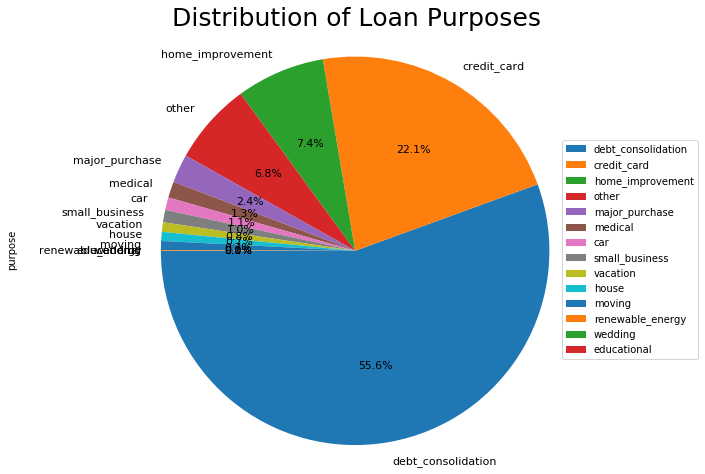

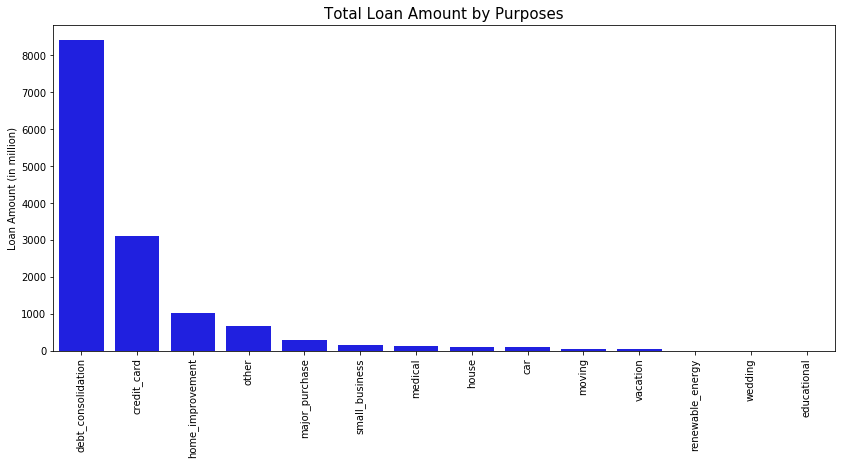

In [11]:
loan_data.loan_purpose('purpose','loan_amnt')

**Insight 1: Loan Purposes**
- The top 1 loan purpose is Debt Consolidation with 55.6%,  following by is Credit Card with 22.1%, next is loan for Home Improvement 7.4%. Many others purposes that sums 14.9%.
- It is easier to understand that the total of loan amount by purpose is similar with its distribution. Top is loan for Debt Consolidation with more than USD8,000 million, second rank is Credit card with around USD3,000 million and next is Home Improvement wiht arounf USD1,000 million.

**2. LOAN AMOUNT BY YEARS/TERM**

issue_year
2015     227.205300
2016    4221.586200
2017    4441.629675
2018    5197.793900
Name: loan_amnt, dtype: float64


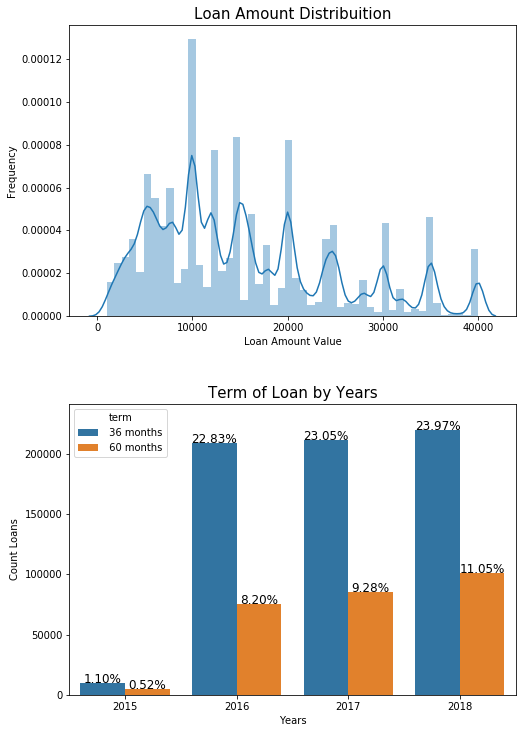

In [12]:
loan_data.loan_by_year('loan_amnt', 'issue_year','term')

**Insight 2: Loan Amount By Year**
- The total loan amount increased significantly from USD227.21 million in 2015 to USD5197.79 million in 2018.
- We can note that a big part of the loans were values until USD 10,000, however we still need to check outliers.
- Loan with term of 36 months was much higher than that of term of 60 months, and it kept consistant from 2016-2018.

**3. INTEREST RATE vs. GRADE/SUB-GRADE**

Average Rate by Grades
grade
A     7.023791
B    10.587208
C    14.244344
D    18.857020
E    23.859889
F    27.679783
G    30.077925
Name: int_rate, dtype: float64


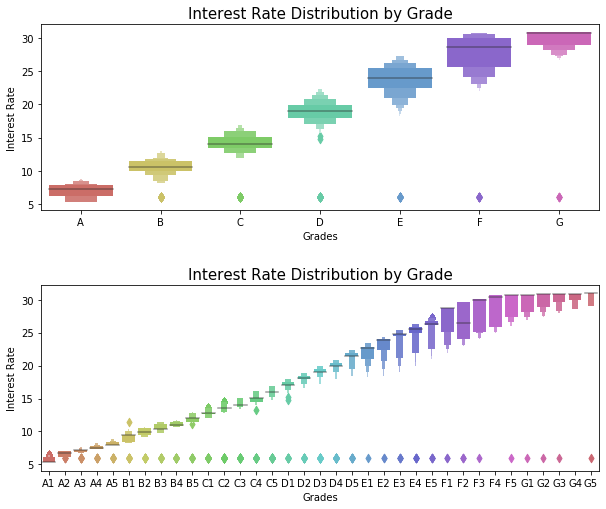

In [13]:
loan_data.rate('int_rate', 'grade', 'sub_grade')

**Insight 3:**
- Average interate rate increases from grade A to grade G and the gap of average rate among 5 grades is significant. While average rate of Grade A is just 7%, this figure for Grade G is > 30%.
- Two box plots show us clearer the relationship between Interest rate and Grade/Sub-grade. The "higher" grade/sub-grade, the higher interest rate.
- As we can see from the box plots, there are some outliers.

**4. LOAN AMOUNT Vs. STATES**

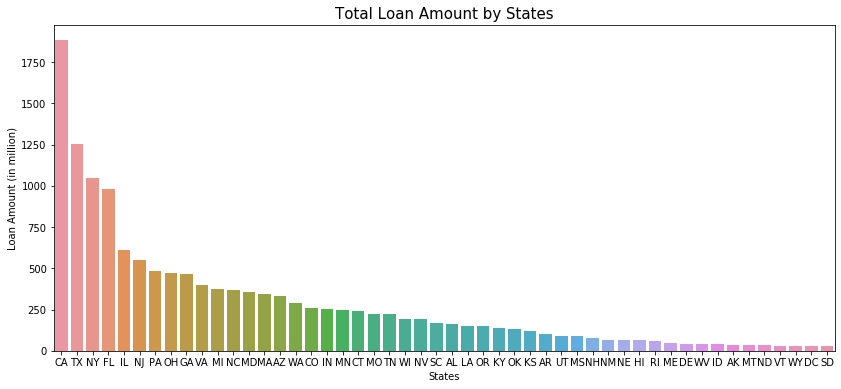

In [14]:
loan_data.states('addr_state','loan_amnt')

**Insight 4: Loan Amount by States**
- As we can see from bar chart, there is the significant difference in total loan amount by states. 
- California is the state having the highest total loan amount and the lowest one is South Carolina.
- Top 5 States with highest Loan Amount are California, Texas, New York, Florida and Illinois.

**5. LOAN AMOUNT Vs. ANNUAL INCOME**

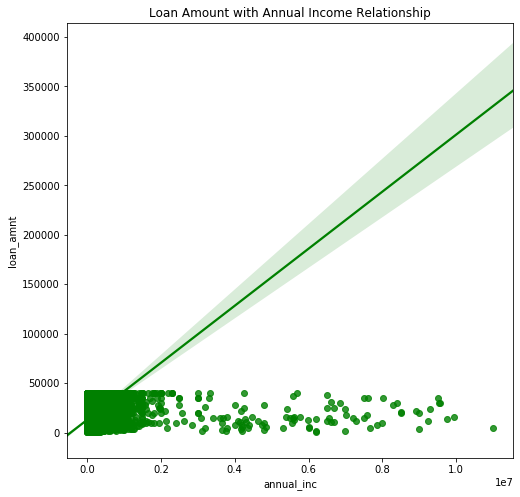

In [15]:
loan_data.loan_income('annual_inc','loan_amnt')

**Insight 5:**
- As the plot shows, there is no significant relationship between Annual income of borrowers and Loan Amount.
Therefore Annual Income does not affect much to the Loan Amount.

**6. LOAN Vs. EMPLOYMENT TITLE**

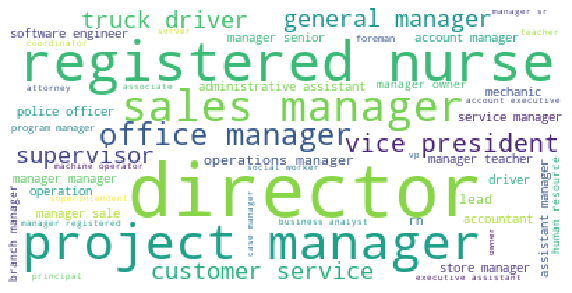

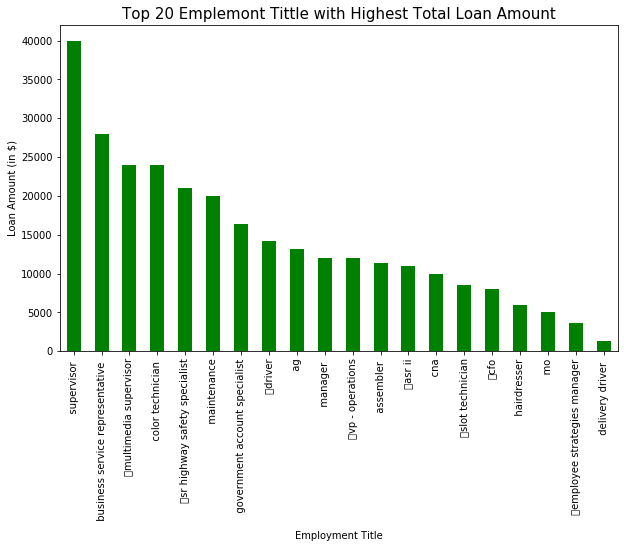

In [16]:
loan_data.emp_title('emp_title','loan_amnt')

**Insight 6:**
- The wordcloud shows the top 50 words that are the most trending of employment titles of borrowers.
Most popular employment title are related to "director", "register nurse", "project manager", "office manager",...
- The bar chart showS Top 20 employment titles  with highest total loan amount. 
We can see that "sunpervisor" is rank 1, followed by is "business service representative" and "multimedia supervisor".

**7. LOAN STATUS**

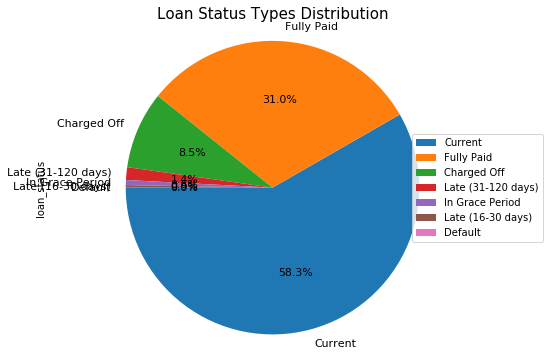

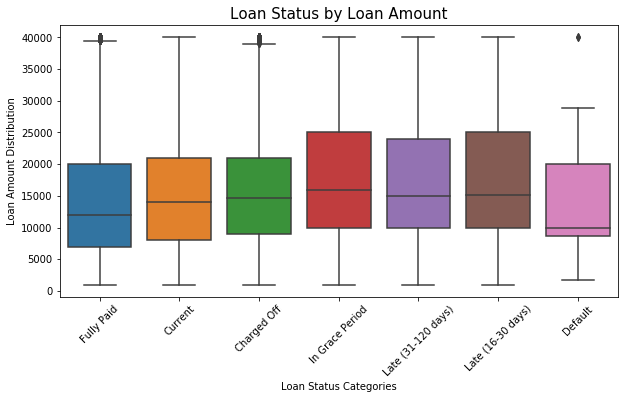

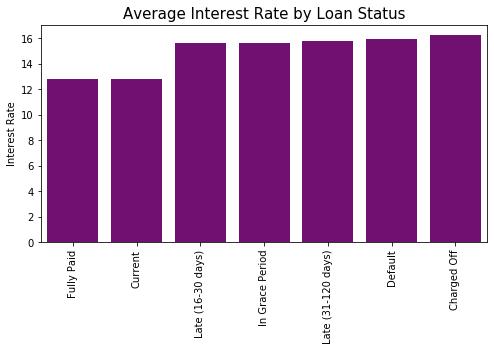

In [17]:
loan_data.loan_status('loan_status', 'loan_amnt', 'int_rate')

**Insight 7:**
- Current type Loan Status is the highest share in number of loan with 58.3%, followed by is Fully Paid type with 31%.
The lowest type belongs to Default.
- We can see Default loan status type has the lowest values in loan amount distribution.
- From the third chart, it is easy to understand that the average interest rate for Fully Paid and Current status are lower than those of Late status.

**8. APPLICATION TYPES Vs. LOAN/RATE**

Individual    841539
Joint App      75933
Name: application_type, dtype: int64


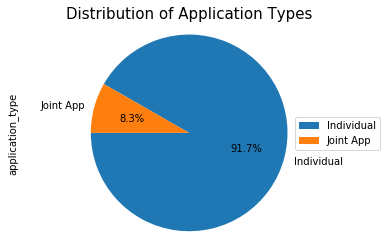

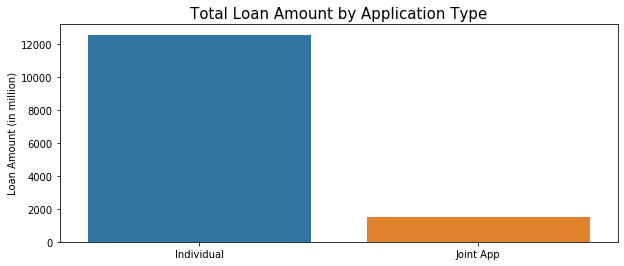

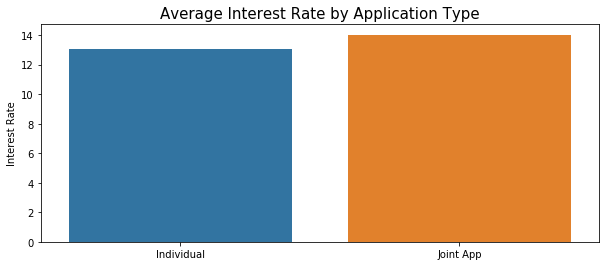

In [18]:
loan_data.app_types('application_type', 'loan_amnt', 'int_rate')

**Insight 8:**
- This is interesting that Individual appplication holds more than 90% of number of loans, 
and also keeps much higher share in total of loan amount than Join application.
- The average interate rate of Join application is slightly higher than that of Individual application.

**9. HOME OWNERSHIP Vs. LOAN/RATE**

MORTGAGE    466391
RENT        351191
OWN          99342
ANY            547
NONE             1
Name: home_ownership, dtype: int64


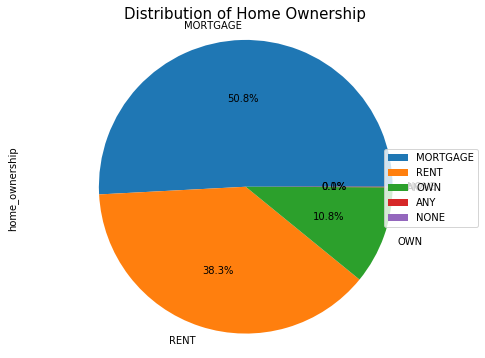

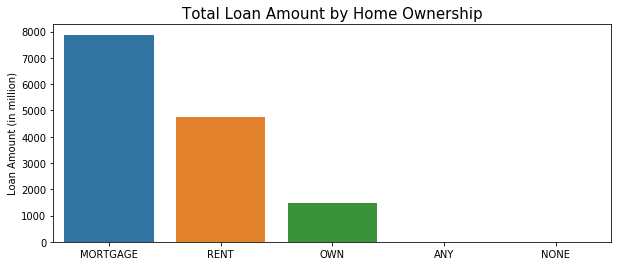

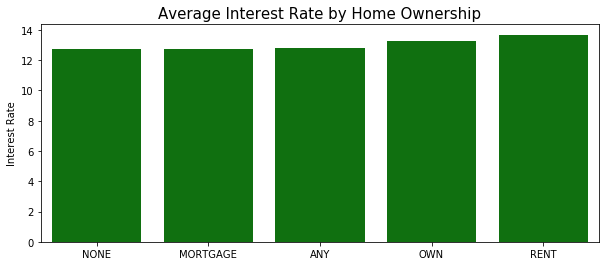

In [19]:
loan_data.home_ownership('home_ownership','loan_amnt', 'int_rate')

**Insight 9:**
- Mortgage home ownership keep the highest share in number of loan with > 50%, followed by is Rent ~38%, next is Own.
- Mortgage home ownership also is Top 1 in total loan amount, with around USD8,000 million, next is Rent ownership 
with around USD5,000 million and Own with around USD 1,500 million.
- Overall, there is not significant difference of average interest rate among these home ownership. 
Average rate for mortgage home owneship is sligtly lowers than those of Own and Rent.

**10. INSTALLMENT**

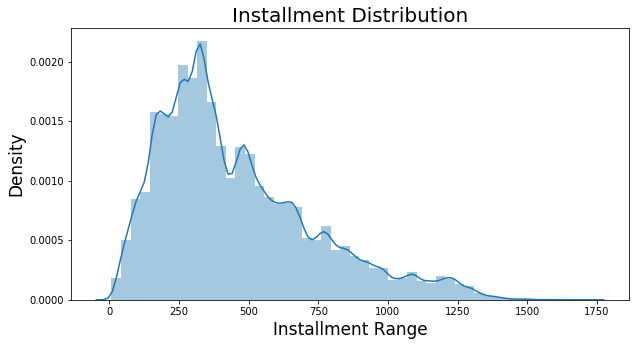

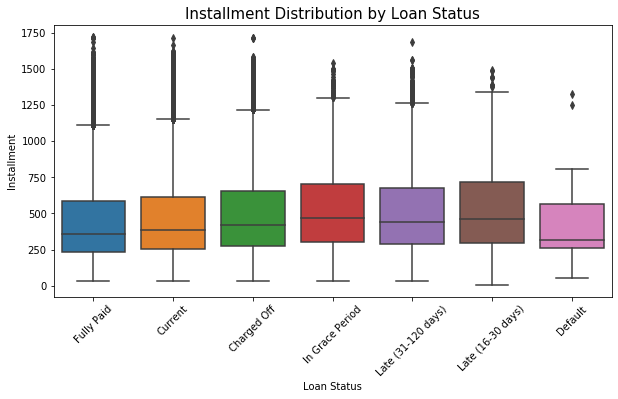

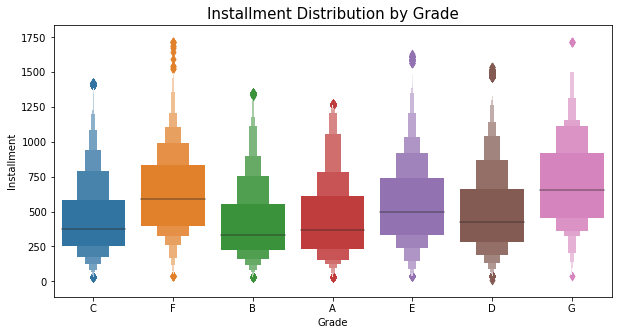

In [20]:
loan_data.installment('installment', 'loan_status', 'grade')

**Insight 10:**
- We can see that the peak of installment distribution is USD~300/month. Installment ranges upto USD1,750/month
- Default Loan Status has the lowes value in Installment distribution.
- Grade A,B,C have the low values in Installment distribution, while Grade G and F have the high values in Installment distribution.
- There are some outliers that we need to consider in buiding predict modeling.